In [68]:
!pip install scikit-learn
!pip install matplotlib
!pip install pillow
!pip install seaborn



   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----------------- ---------------------- 4.7/11.1 MB 57.1 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.1 MB 13.6 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.1 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 16.5 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 

In [58]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = r'D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [59]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [61]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Callbacks
checkpoint = ModelCheckpoint('best_resnet_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint]
)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 1.2798 - accuracy: 0.4200  
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to best_resnet_model.h5
88/88 [==============================] - 38s 397ms/step - loss: 1.2798 - accuracy: 0.4200 - val_loss: 1.2399 - val_accuracy: 0.4200
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 1.0785 - accuracy: 0.5214 
Epoch 2: val_accuracy improved from 0.42000 to 0.47833, saving model to best_resnet_model.h5
88/88 [==============================] - 12s 135ms/step - loss: 1.0785 - accuracy: 0.5214 - val_loss: 1.1175 - val_accuracy: 0.4783
Epoch 3/50
87/88 [============================>.] - ETA: 0s - loss: 1.0285 - accuracy: 0.5510 
Epoch 3: val_accuracy improved from 0.47833 to 0.55333, saving model to best_resnet_model.h5
88/88 [==============================] - 11s 122ms/step - loss: 1.0277 - accuracy: 0.5511 - val_loss: 1.0349 - val_accuracy: 0.5533
Epoch 4/50
88/88 [========================

19/19 [==============================] - 6s 288ms/step
Accuracy: 0.7483333333333333
mAP: 0.8292965175263837


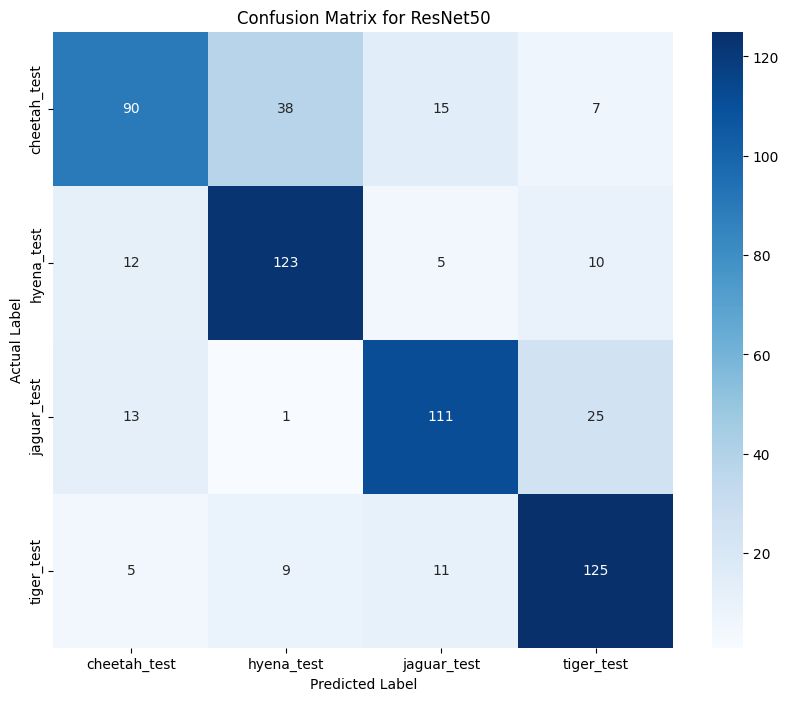

Classification Report for ResNet50
              precision    recall  f1-score   support

cheetah_test       0.75      0.60      0.67       150
  hyena_test       0.72      0.82      0.77       150
 jaguar_test       0.78      0.74      0.76       150
  tiger_test       0.75      0.83      0.79       150

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600



In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Load the best model
model = tf.keras.models.load_model('best_resnet_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = r'D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))

In [10]:
imgs , labels = next(train_batches)

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..108.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..122.32].
Clipping input data t

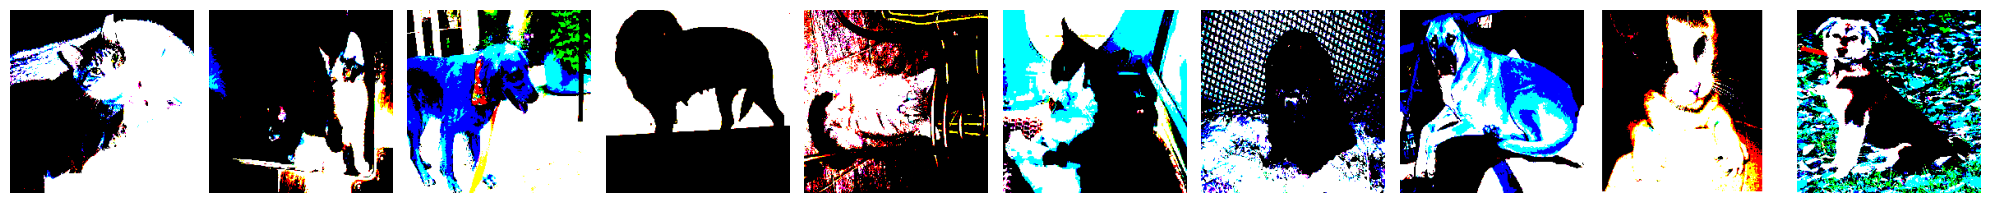

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [12]:
plotImages(imgs)
print(labels)

In [13]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same',input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
history1 = model.fit(x=train_batches, validation_data = valid_batches, epochs =10, verbose = 2)

Epoch 1/10
100/100 - 21s - loss: 24.9908 - accuracy: 0.5430 - val_loss: 8.7171 - val_accuracy: 0.5650 - 21s/epoch - 211ms/step
Epoch 2/10
100/100 - 3s - loss: 4.6923 - accuracy: 0.7010 - val_loss: 4.2201 - val_accuracy: 0.6150 - 3s/epoch - 27ms/step
Epoch 3/10
100/100 - 3s - loss: 0.6215 - accuracy: 0.8830 - val_loss: 2.9417 - val_accuracy: 0.6250 - 3s/epoch - 26ms/step
Epoch 4/10
100/100 - 2s - loss: 0.2025 - accuracy: 0.9420 - val_loss: 3.3374 - val_accuracy: 0.5950 - 2s/epoch - 25ms/step
Epoch 5/10
100/100 - 3s - loss: 0.0366 - accuracy: 0.9860 - val_loss: 2.5382 - val_accuracy: 0.6250 - 3s/epoch - 26ms/step
Epoch 6/10
100/100 - 3s - loss: 0.0065 - accuracy: 0.9980 - val_loss: 2.5609 - val_accuracy: 0.6550 - 3s/epoch - 25ms/step
Epoch 7/10
100/100 - 3s - loss: 0.0080 - accuracy: 0.9970 - val_loss: 2.3023 - val_accuracy: 0.6450 - 3s/epoch - 26ms/step
Epoch 8/10
100/100 - 3s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.2811 - val_accuracy: 0.6500 - 3s/epoch - 27ms/step
Epoch 9/10
1

# Model Accuracy

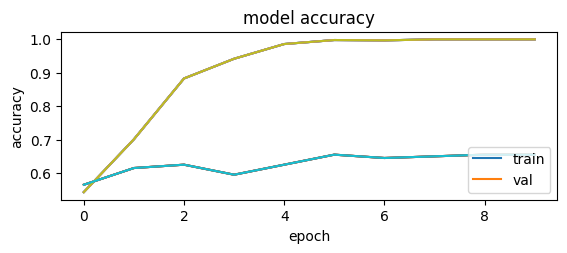

In [21]:
plt.subplot(2,1,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.show()


# Training Loss

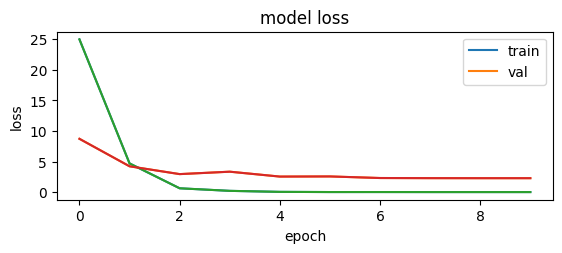

In [23]:
plt.subplot(2,1,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-93.939..121.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..118.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-114.68..133.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.68..151.061].
Clipping input data to

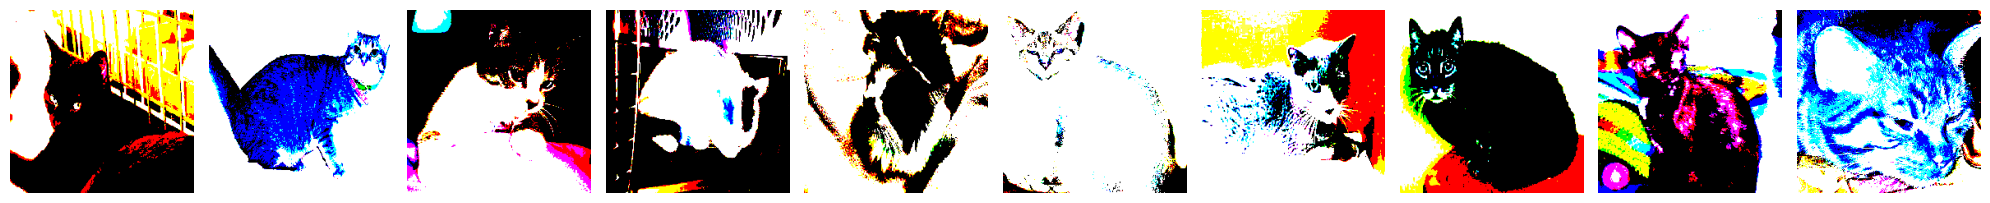

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [24]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [25]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
predictions = model.predict(x=test_batches, verbose=0)

In [27]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [28]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [29]:
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [30]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[27 23]
 [16 34]]


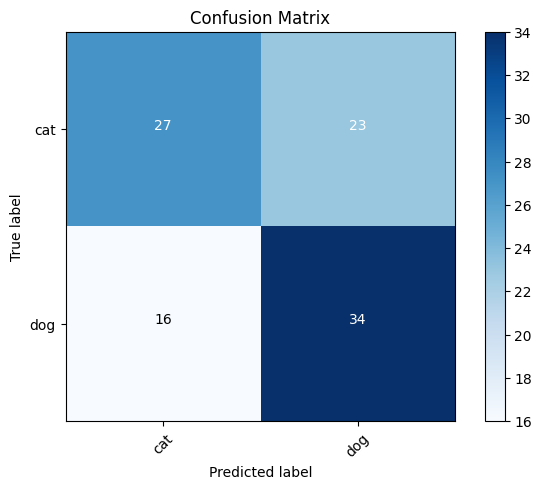

In [34]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()

In [35]:
loss,acc = model.evaluate(test_imgs, test_labels, batch_size=10)

1/1 [==============================] - 0s 44ms/step - loss: 2.9427 - accuracy: 0.4000


# Pre-trained on ResNet50 network

## Load the the model fom Keras library

In [36]:
resnet50_model = tf.keras.applications.resnet50.ResNet50()

102967424/102967424 [==============================] - 9s 0us/step


In [37]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### From the above model summary there are about 138 millions parameters!

In [39]:
type(resnet50_model)

keras.engine.functional.Functional

In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: cat, dog

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 8s 0us/step


In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [44]:
history2 = model.fit(x=train_batches, steps_per_epoch = len(train_batches), validation_data = valid_batches, validation_steps=len(valid_batches),
         epochs = 5, verbose =2)

Epoch 1/5
100/100 - 7s - loss: 0.2127 - accuracy: 0.9100 - val_loss: 0.0990 - val_accuracy: 0.9600 - 7s/epoch - 74ms/step
Epoch 2/5
100/100 - 3s - loss: 0.0504 - accuracy: 0.9890 - val_loss: 0.0930 - val_accuracy: 0.9550 - 3s/epoch - 35ms/step
Epoch 3/5
100/100 - 3s - loss: 0.0268 - accuracy: 0.9980 - val_loss: 0.0799 - val_accuracy: 0.9700 - 3s/epoch - 33ms/step
Epoch 4/5
100/100 - 3s - loss: 0.0162 - accuracy: 0.9990 - val_loss: 0.0809 - val_accuracy: 0.9650 - 3s/epoch - 34ms/step
Epoch 5/5
100/100 - 3s - loss: 0.0106 - accuracy: 0.9990 - val_loss: 0.0931 - val_accuracy: 0.9700 - 3s/epoch - 35ms/step


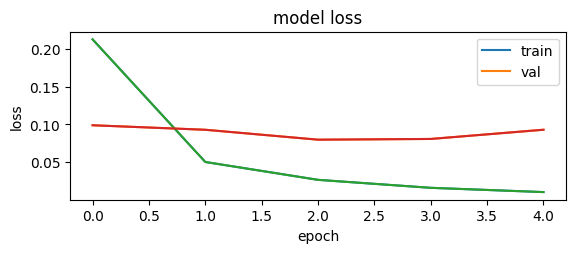

In [46]:
plt.subplot(2,1,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()


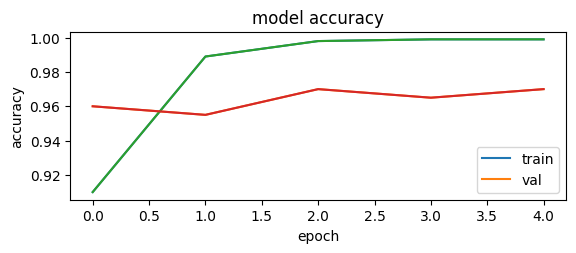

In [48]:
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.show()

In [49]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-106.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..84.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

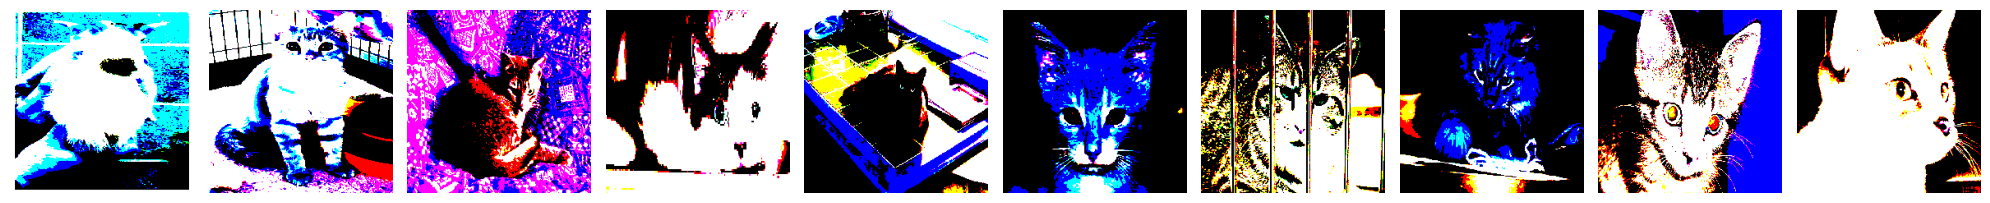

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [50]:
plotImages(test_imgs)
print(test_labels)

In [51]:
predictions = model.predict(x=test_batches, steps = len(test_batches), verbose = 0)

In [52]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [53]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))


In [54]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[50  0]
 [ 0 50]]


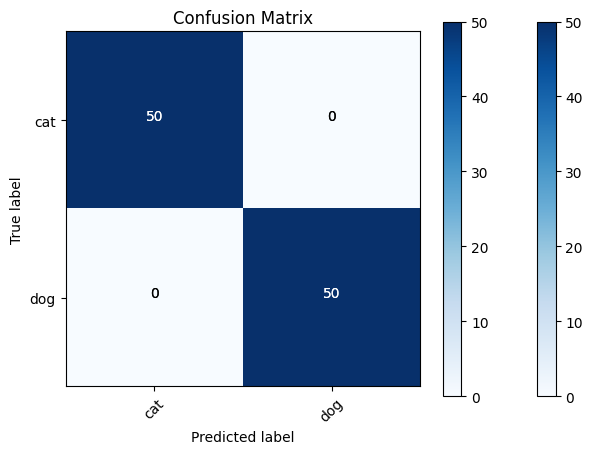

In [57]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = 'Confusion Matrix')

plt.show()

In [56]:
loss,acc = model.evaluate(test_imgs, test_labels, batch_size=10)

1/1 [==============================] - 0s 64ms/step - loss: 0.0939 - accuracy: 1.0000
